# TensorFlow

**[OFE-01]** 必要なモジュールをインポートします。

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle  # Python3にはcPikleではなくpickleしかない  みんなのPython P404
# import pickle

**[OFE-02]** データファイル「ORENIST.data」から画像とラベルのデータを読み込みます。

In [2]:
with open('ORENIST.data', 'rb') as file:
    images, labels = pickle.load(file, encoding='latin1') 
    # Python2系でpickle化したものはencodingを指定しないとunpickle化できない． latin1を指定してやると上手くいく

**[OFE-03]** 画像データのサンプルを表示します。

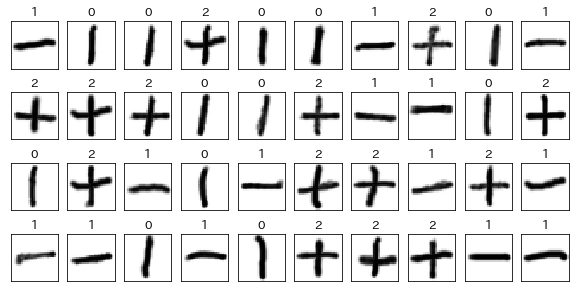

In [3]:
fig = plt.figure(figsize=(10,5))
for i in range(40):
    subplot = fig.add_subplot(4, 10, i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('%d' % np.argmax(labels[i]))
    subplot.imshow(images[i].reshape(28,28), vmin=0, vmax=1,
                   cmap=plt.cm.gray_r, interpolation='nearest')

**[OFE-04]** フィルターの情報を格納した多次元リストを作る関数を用意します。

In [4]:
def edge_filter():
    filter0 = np.array(
            [[ 2, 1, 0,-1,-2],
             [ 3, 2, 0,-2,-3],
             [ 4, 3, 0,-3,-4],
             [ 3, 2, 0,-2,-3],
             [ 2, 1, 0,-1,-2]]) / 23.0
    filter1 = np.array(
            [[ 2, 3, 4, 3, 2],
             [ 1, 2, 3, 2, 1],
             [ 0, 0, 0, 0, 0],
             [-1,-2,-3,-2,-1],
             [-2,-3,-4,-3,-2]]) / 23.0
    
    filter_array = np.zeros([5,5,1,2])
    filter_array[:,:,0,0] = filter0
    filter_array[:,:,0,1] = filter1

    print("filter shape: ",  filter_array.shape)
    return tf.constant(filter_array, dtype=tf.float32)

**[OFE-05]** 画像データにフィルターを適用する計算式を用意します。

In [5]:
x = tf.placeholder(tf.float32, [None, 784])

# tf.reshape: Reshapes a tensor.
x_image = tf.reshape(x, [-1,28,28,1])  # tf.nn.conv2dがdata_format='NHWC'なのでそれに合わせる．

W_conv = edge_filter()

# filter_shape: [filter_height, filter_width, in_channels=data_channels , out_channels=kind of filter]
h_conv = tf.abs(tf.nn.conv2d(input=x_image, filter=W_conv, 
                             strides=[1,1,1,1], padding='SAME'))
h_conv_cutoff = tf.nn.relu(h_conv-0.2)

# poolingのkernel(window) size とstrideは同じ値に設定するのが一般的
# pooling のフィルタは学習すべきパラメータがなく，フィルタはデータ数・チャンネル数で共通の１つだけで良い
# よって必ずshape=[1, FH, FW, 1]である．
h_pool =tf.nn.max_pool(h_conv_cutoff, ksize=[1,2,2,1],
                       strides=[1,2,2,1], padding='SAME')

filter shape:  (5, 5, 1, 2)



tf.nn.conv2d関数のpadding引数に'SAME'を与えると,畳み込みすると切れる部分にはゼロpaddingが行われる．  
詳しくは以下を参照

https://qiita.com/tadOne/items/48302a399dcad44c69c8

stride引数には以下の注意が必要  
Must have strides[0] = strides[3] = 1. For the most common case of the same horizontal and vertices strides, strides = [1, stride, stride, 1].

**[OFE-06]** セッションを用意して、Variable を初期化します。

In [6]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

**[OFE-07]** 最初の9個分の画像データに対して、畳み込みフィルターを適用した結果を計算します。

In [7]:
filter_vals, conv_vals = sess.run([W_conv, h_conv_cutoff],
                                  feed_dict={x:images[:9]})

In [8]:
conv_vals.shape  # 畳み込みで返ってくる値はdata_formatの指定('NHWC')と同じ

(9, 28, 28, 2)

In [9]:
conv_vals[0, :, :, 1].shape

(28, 28)

**[OFE-08]** 得られた結果を画像として表示します。

ここでは、オリジナルの画像と2種類のフィルターを適用したそれぞれの結果を表示しています。

左端は、適用したフィルターを画像化したものです。

0.79096335

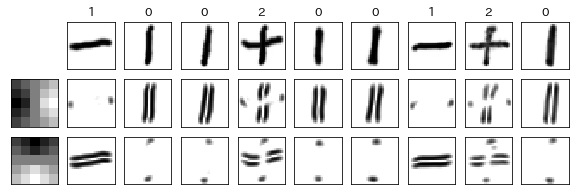

In [10]:
fig = plt.figure(figsize=(10,3))

# フィルターの画像を表示
for i in range(2):
    subplot = fig.add_subplot(3, 10, 10*(i+1)+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(filter_vals[:,:,0,i],
                   cmap=plt.cm.gray_r, interpolation='nearest')

v_max = np.max(conv_vals)

# データ， 畳み込み後の画像を表示
for i in range(9):
    # データを表示
    subplot = fig.add_subplot(3, 10, i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('%d' % np.argmax(labels[i]))
    subplot.imshow(images[i].reshape((28,28)), vmin=0, vmax=1,
                   cmap=plt.cm.gray_r, interpolation='nearest')
    
    # フィルター１の畳み込み結果を表示
    subplot = fig.add_subplot(3, 10, 10+i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(conv_vals[i,:,:,0], vmin=0, vmax=v_max, 
                   cmap=plt.cm.gray_r, interpolation='nearest')
    
    # フィルター１の畳み込み結果を表示
    subplot = fig.add_subplot(3, 10, 20+i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(conv_vals[i,:,:,1], vmin=0, vmax=v_max,
                   cmap=plt.cm.gray_r, interpolation='nearest')
v_max

**[OFE-09]** フィルターに加えて、プーリング層を適用した結果を取得します。

In [11]:
pool_vals = sess.run(h_pool, feed_dict={x:images[:9]})
pool_vals.shape

(9, 14, 14, 2)

**[OFE-10]** 得られた結果を画像として表示します。

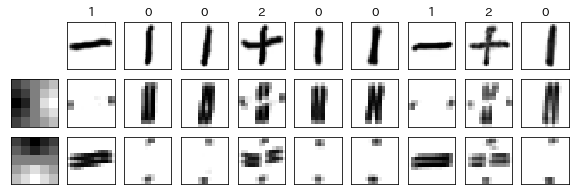

In [12]:
fig = plt.figure(figsize=(10,3))

for i in range(2):
    subplot = fig.add_subplot(3, 10, 10*(i+1)+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(filter_vals[:,:,0,i],
                   cmap=plt.cm.gray_r, interpolation='nearest')

v_max = np.max(pool_vals)

for i in range(9):
    subplot = fig.add_subplot(3, 10, i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('%d' % np.argmax(labels[i]))
    subplot.imshow(images[i].reshape((28,28)), vmin=0, vmax=1,
                   cmap=plt.cm.gray_r, interpolation='nearest')
    
    subplot = fig.add_subplot(3, 10, 10+i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(pool_vals[i,:,:,0], vmin=0, vmax=v_max,
                   cmap=plt.cm.gray_r, interpolation='nearest')
    
    subplot = fig.add_subplot(3, 10, 20+i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(pool_vals[i,:,:,1], vmin=0, vmax=v_max,
                   cmap=plt.cm.gray_r, interpolation='nearest')

# Keras

In [15]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.core import Activation, Lambda
from keras.layers.pooling import MaxPooling2D

In [20]:
model = Sequential()

In [17]:
def weight_init(shape, dtype=None):
#def weight_init():
    filter0 = np.array(
            [[ 2, 1, 0,-1,-2],
             [ 3, 2, 0,-2,-3],
             [ 4, 3, 0,-3,-4],
             [ 3, 2, 0,-2,-3],
             [ 2, 1, 0,-1,-2]]) / 23.0
    filter1 = np.array(
            [[ 2, 3, 4, 3, 2],
             [ 1, 2, 3, 2, 1],
             [ 0, 0, 0, 0, 0],
             [-1,-2,-3,-2,-1],
             [-2,-3,-4,-3,-2]]) / 23.0
    
    filter_array = np.zeros([5,5,1,2])
    filter_array[:,:,0,0] = filter0
    filter_array[:,:,0,1] = filter1

    print("filter shape: ",  filter_array.shape)
    return filter_array

In [21]:
conv = Conv2D(filters=2, kernel_size=5,
                 padding="same",
                 data_format="channels_last",
                 use_bias=False,
                 input_shape=(28, 28, 1),
                  kernel_initializer=weight_init) 
model.add(conv)

filter shape:  (5, 5, 1, 2)


In [22]:
model.add(Lambda(lambda x: x - 0.2))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding="same", data_format="channels_last"))

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 2)         50        
_________________________________________________________________
lambda_3 (Lambda)            (None, 28, 28, 2)         0         
_________________________________________________________________
activation_3 (Activation)    (None, 28, 28, 2)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 2)         0         
Total params: 50
Trainable params: 50
Non-trainable params: 0
_________________________________________________________________


In [26]:
conv_vals = model.predict(array_images, verbose=0)

In [24]:
array_images = np.array(images[:9])

In [25]:
array_images = array_images.reshape(-1,28,28,1)

In [27]:
conv_vals.shape

(9, 14, 14, 2)

0.79096335

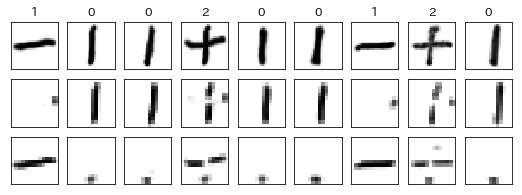

In [29]:
fig = plt.figure(figsize=(10,3))
v_max = np.max(conv_vals)

# データ， 畳み込み後の画像を表示
for i in range(9):
    # データを表示
    subplot = fig.add_subplot(3, 10, i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('%d' % np.argmax(labels[i]))
    subplot.imshow(images[i].reshape((28,28)), vmin=0, vmax=1,
                   cmap=plt.cm.gray_r, interpolation='nearest')
    
    # フィルター１の畳み込み結果を表示
    subplot = fig.add_subplot(3, 10, 10+i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(conv_vals[i,:,:,0], vmin=0, vmax=v_max, 
                   cmap=plt.cm.gray_r, interpolation='nearest')
    
    # フィルター１の畳み込み結果を表示
    subplot = fig.add_subplot(3, 10, 20+i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(conv_vals[i,:,:,1], vmin=0, vmax=v_max,
                   cmap=plt.cm.gray_r, interpolation='nearest')
v_max

In [25]:
model.layers[0].get_weights()[0].shape

(5, 5, 1, 2)

In [26]:
model.layers[0].input_shape

(None, 28, 28, 1)

In [29]:
model.layers[0].output_shape

(None, 28, 28, 2)